# **Training MLP Network**

# **1-1 Dataset**

In [59]:
from IPython.display import clear_output
from keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from itertools import cycle
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install unrar
!unrar x './drive/MyDrive/NN_HW2_Face_Emotion.rar';

Streaming output truncated to the last 5000 lines.
Extracting  TRAIN/fear/image0000694.jpg                                   24%  OK 
Extracting  TRAIN/fear/image0000701.jpg                                   24%  OK 
Extracting  TRAIN/fear/image0000777.jpg                                   24%  OK 
Extracting  TRAIN/fear/image0000808.jpg                                   24%  OK 
Extracting  TRAIN/fear/image0000815.jpg                                   24%  OK 
Extracting  TRAIN/fear/image0000842.jpg                                   24%  OK 
Extracting  TRAIN/fear/image0000843.jpg                                   24%  OK 
Extracting  TRAIN/fear/image0000915.jpg                                   24%  OK 
Extracting  TRAIN/fear/image0001001.jpg                                   24%  OK 
Extracting  TRAIN/fear/image0001038.jpg                                   24%  OK 
Extracting  TRAIN/fear/image0

In [4]:
train_datagen = ImageDataGenerator(
        rescale = 1/255.0,
        rotation_range = 20,
        zoom_range = 0,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        shear_range = 0,
        horizontal_flip = True,
        fill_mode = "nearest",
        validation_split = 0.2)

tune_datagen = ImageDataGenerator(
        rescale = 1/255.0,
        rotation_range = 20,
        zoom_range = 0,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        shear_range = 0,
        horizontal_flip = True,
        fill_mode = "nearest",
        validation_split = 0.2)

train_DS = train_datagen.flow_from_directory(
    directory="TRAIN",
    target_size = (128, 128),
    color_mode="rgb",
    batch_size=400,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42)

validation1_DS = train_datagen.flow_from_directory(
    directory="TRAIN",
    target_size = (128, 128),
    color_mode="rgb",
    batch_size=400,
    class_mode="categorical",
    subset='validation',
    shuffle=False,
    seed=42)

tune_DS = tune_datagen.flow_from_directory(
    directory="TUNE",
    target_size = (128, 128),
    color_mode="rgb",
    batch_size=400,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42)

validation2_DS = tune_datagen.flow_from_directory(
    directory="TUNE",
    target_size = (128, 128),
    color_mode="rgb",
    batch_size=400,
    class_mode="categorical",
    subset='validation',
    shuffle=False,
    seed=42)

Found 6400 images belonging to 8 classes.
Found 1600 images belonging to 8 classes.
Found 1280 images belonging to 8 classes.
Found 320 images belonging to 8 classes.


# **1-2 Samples**

In [5]:
labs = []
imags = []
i = 0
while len(labs) < 8:
     if (np.where((train_DS[0][1][i]) == 1)[0][0] in labs):
          i += 1
          continue
     imags.append(train_DS[0][0][i])
     labs.append(np.where((train_DS[0][1][i]) == 1)[0][0])
     i += 1

{'anger': 0, 'contempt': 1, 'disgust': 2, 'fear': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprise': 7}


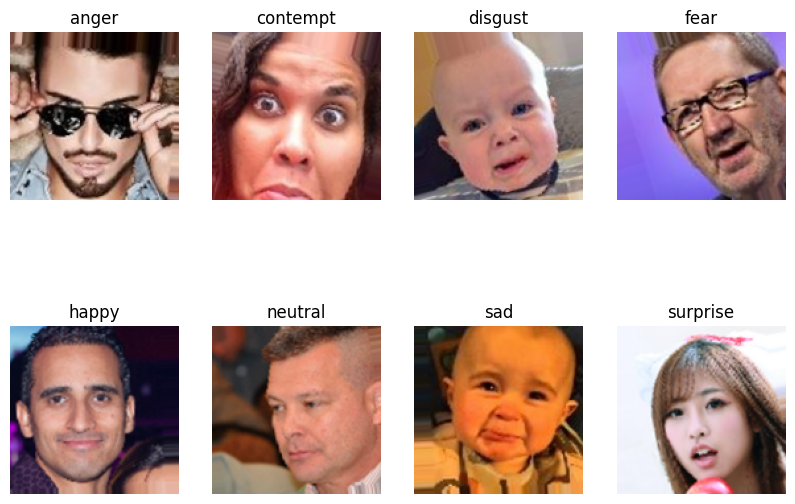

In [6]:
class_names = train_DS.class_indices
print(class_names)

fig = plt.figure(figsize=(10, 7))

for images, labels in zip(imags, labs):
    fig.add_subplot(2, 4, int(labels)+1)
    plt.imshow(images)
    plt.title(list(class_names.keys())[int(labels)])
    plt.axis("off")

In [7]:
train_DS.reset()

# **1-3 Alexnet model**

In [8]:
AlexNet_baseModel = tf.keras.Sequential([

    # CONV 1
    tf.keras.layers.Conv2D(filters=16, input_shape=(128,128,3), kernel_size=(9,9), strides=(1,1), padding="same"),  #   activation="relu"
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    # MAX POOL 1
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    # Dropout 1
    tf.keras.layers.GaussianDropout(0.2, input_shape=(64,64,3)),

    # CONV 2
    tf.keras.layers.Conv2D(filters=32, input_shape=(64,64,3), kernel_size=(7,7), strides=(1,1), padding="same"),  #   activation="relu"
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    # MAX POOL 2
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    # Dropout 2
    tf.keras.layers.GaussianDropout(0.2, input_shape=(32,32,3)),

    # CONV 3
    tf.keras.layers.Conv2D(filters=64, input_shape=(32,32,3), kernel_size=(5,5), strides=(1,1), padding="same"),  #   activation="relu"
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    # MAX POOL 3
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    # Dropout 3
    tf.keras.layers.GaussianDropout(0.2, input_shape=(16,16,3)),

    # CONV 4
    tf.keras.layers.Conv2D(filters=128, input_shape=(16,16,3), kernel_size=(3,3), strides=(1,1), padding="same"),  #   activation="relu"
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    # MAX POOL 4
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    # Dropout 4
    tf.keras.layers.GaussianDropout(0.2, input_shape=(8,8,3)),

    # CONV 5
    tf.keras.layers.Conv2D(filters=128, input_shape=(8,8,3), kernel_size=(3,3), strides=(1,1), padding="same"),  #   activation="relu"
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    # MAX POOL 5
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    # Dropout 5
    tf.keras.layers.GaussianDropout(0.2, input_shape=(4,4,3)),

    # Flatten
    tf.keras.layers.Flatten(),

    # Dense 1
    tf.keras.layers.Dense(1024),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    # Dropout 1
    tf.keras.layers.GaussianDropout(0.5),

    # Dense 2
    tf.keras.layers.Dense(1024),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    # Dropout 2
    tf.keras.layers.GaussianDropout(0.5),
])

In [9]:
# updatable plot

class PlotParams(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.acc = []

        self.fig = plt.figure()

        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('accuracy'))
        self.i += 1

        clear_output(wait=True)
        plt.subplot(2,1,1)
        plt.plot(self.x, self.losses, label="loss")
        plt.legend()
        plt.subplot(2,1,2)
        plt.plot(self.x, self.acc, label="accuracy")
        plt.legend()
        plt.show();

plot_params = PlotParams()

In [10]:
AlexNet_headModel = AlexNet_baseModel.output
# Output Layer
AlexNet_headModel = tf.keras.layers.Dense(8) (AlexNet_headModel)
AlexNet_headModel = tf.keras.layers.Softmax() (AlexNet_headModel)

AlexNet_Model = tf.keras.Model(inputs=AlexNet_baseModel.input, outputs=AlexNet_headModel)

AlexNet_Model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      3904      
                                                                 
 batch_normalization (Batch  (None, 128, 128, 16)      64        
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 128, 128, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)        0         
 D)                                                              
                                                                 
 gaussian_dropout (Gaussian  (None, 64, 64, 16)        0     

# **1-4 Training**

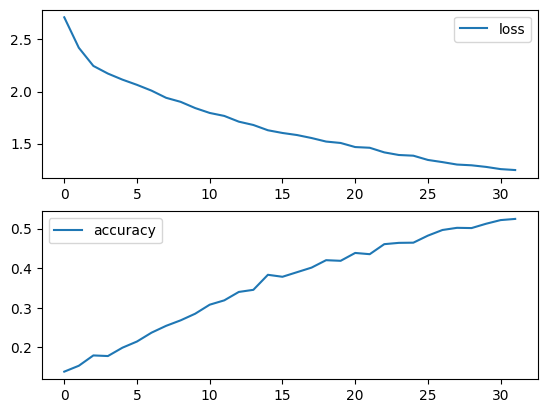

16/16 [==============================] - 41s 2s/step - loss: 1.2468 - accuracy: 0.5242


In [11]:
opt = tf.keras.optimizers.Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
AlexNet_Model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])
AlexNet_Model.fit(train_DS, epochs=32, callbacks=[plot_params])

In [12]:
validation1_DS.reset()
AlexNet_Model.evaluate(validation1_DS)

4/4 [==============================] - 8s 2s/step - loss: 1.6493 - accuracy: 0.4756


[1.6493366956710815, 0.47562500834465027]

# **1-5 Fine-Tuning**

In [35]:
tune_DS.reset()
for layer in AlexNet_baseModel.layers:
	layer.trainable = False

In [36]:
AlexNet_regModel = AlexNet_baseModel.output
# Output Layer
AlexNet_regModel = tf.keras.layers.Dense(8) (AlexNet_regModel)
AlexNet_regModel = tf.keras.layers.Softmax() (AlexNet_regModel)

AlexNet_tuneModel = tf.keras.Model(inputs=AlexNet_baseModel.input, outputs=AlexNet_regModel)

AlexNet_tuneModel.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      3904      
                                                                 
 batch_normalization (Batch  (None, 128, 128, 16)      64        
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 128, 128, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)        0         
 D)                                                              
                                                                 
 gaussian_dropout (Gaussian  (None, 64, 64, 16)        0   

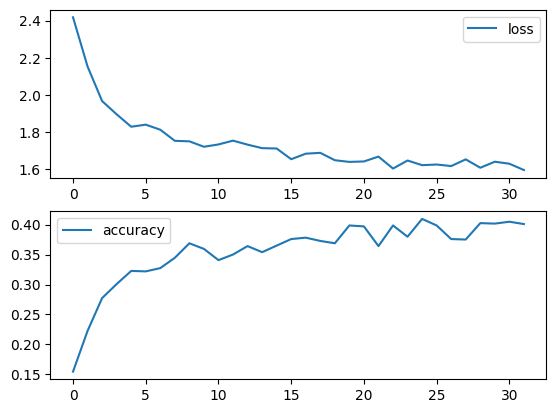

4/4 [==============================] - 7s 1s/step - loss: 1.5952 - accuracy: 0.4008


In [37]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, weight_decay=1e-8)
AlexNet_tuneModel.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])
AlexNet_tuneModel.fit(tune_DS, epochs=32, callbacks=[plot_params])

# **1-6 Evaluation**

In [38]:
validation2_DS.reset()
AlexNet_tuneModel.evaluate(validation2_DS)
validation2_DS.reset()
y_pred = AlexNet_tuneModel.predict(validation2_DS)

1/1 [==============================] - 3s 3s/step


In [54]:
y_pred = tf.one_hot(tf.argmax(y_pred, axis=1), depth = 8)

In [55]:
y_tune = validation2_DS[0][1]

In [56]:
y_pred_enc = np.argmax(y_pred, axis=1)
y_tune_enc = np.argmax(y_tune, axis=1)

In [57]:
print('precision, recall,   f1-score')
print(metrics.precision_recall_fscore_support(y_tune_enc, y_pred_enc, average='micro', warn_for=('precision', 'recall', 'f-score'), zero_division='warn'))
print('------------------------------------------------------')
print(metrics.classification_report(y_tune_enc, y_pred_enc))

precision, recall,   f1-score
(0.403125, 0.403125, 0.40312499999999996, None)
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.35      0.20      0.25        40
           1       0.50      0.38      0.43        40
           2       0.26      0.23      0.24        40
           3       0.59      0.42      0.49        40
           4       0.52      0.95      0.67        40
           5       0.31      0.40      0.35        40
           6       0.36      0.35      0.35        40
           7       0.30      0.30      0.30        40

    accuracy                           0.40       320
   macro avg       0.40      0.40      0.39       320
weighted avg       0.40      0.40      0.39       320



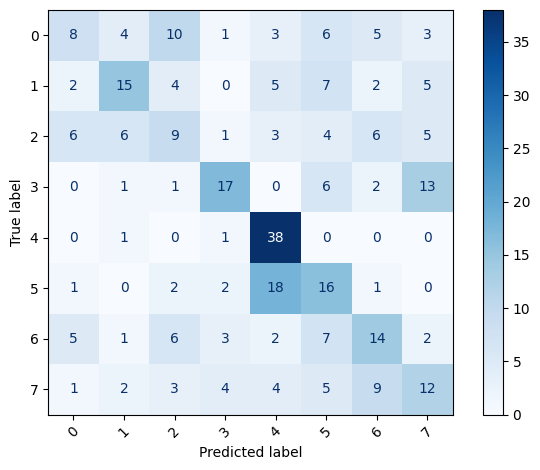

In [60]:
confusion_matrix = confusion_matrix(y_tune_enc, y_pred_enc)
target_names = ["0", "1", "2", "3", "4", "5", "6", "7"]
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)

plt.tight_layout()

class 0 f1 score
0.5862562240378532
class 0 precision score
0.620040989606207
class 0 recall score
0.5732142857142857


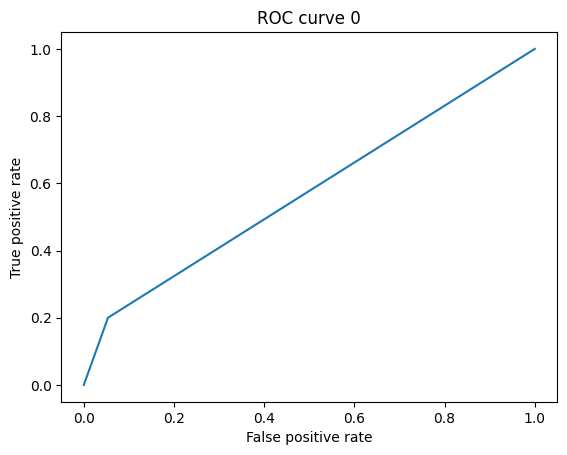

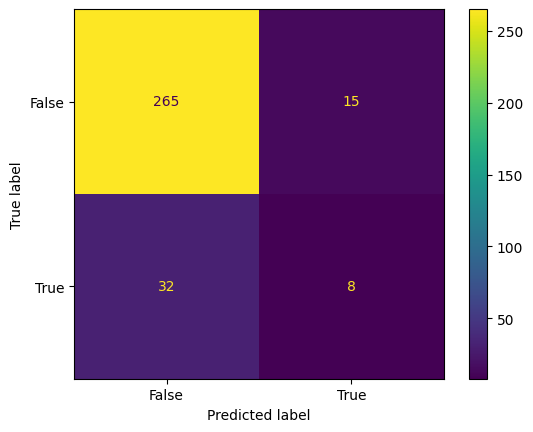

In [61]:
y_pred0 = tf.argmax(y_pred, axis=1) == 0
y_tune0 = tf.argmax(y_tune, axis=1) == 0
fpr0, tpr0, thresholds0 = metrics.roc_curve(y_tune0, y_pred0)
auc_rf0 = metrics.auc(fpr0, tpr0)
plt.plot(fpr0, tpr0, label='Keras (area = {:.3f})'.format(auc_rf0))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve 0')

print("class 0 f1 score")
print(metrics.f1_score(y_tune0, y_pred0, average="macro"))
print("class 0 precision score")
print(metrics.precision_score(y_tune0, y_pred0, average="macro"))
print("class 0 recall score")
print(metrics.recall_score(y_tune0, y_pred0, average="macro"))

confusion_matrix = metrics.confusion_matrix(y_tune0, y_pred0)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()

class 1 f1 score
0.6791979949874686
class 1 precision score
0.7068965517241379
class 1 recall score
0.6607142857142857


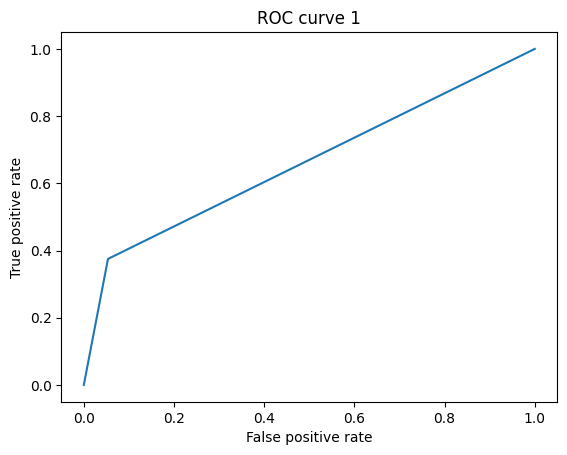

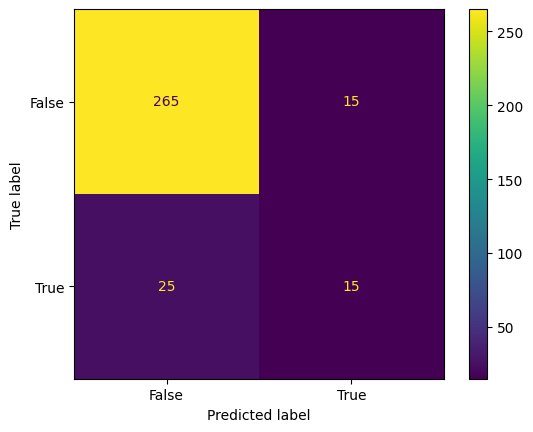

In [62]:
y_pred1 = tf.argmax(y_pred, axis=1) == 1
y_tune1 = tf.argmax(y_tune, axis=1) == 1
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_tune1, y_pred1)
auc_rf1 = metrics.auc(fpr1, tpr1)
plt.plot(fpr1, tpr1, label='Keras (area = {:.3f})'.format(auc_rf1))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve 1')

print("class 1 f1 score")
print(metrics.f1_score(y_tune1, y_pred1, average="macro"))
print("class 1 precision score")
print(metrics.precision_score(y_tune1, y_pred1, average="macro"))
print("class 1 recall score")
print(metrics.recall_score(y_tune1, y_pred1, average="macro"))

confusion_matrix = metrics.confusion_matrix(y_tune1, y_pred1)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()

class 2 f1 score
0.5695575221238938
class 2 precision score
0.5741854636591479
class 2 recall score
0.5660714285714286


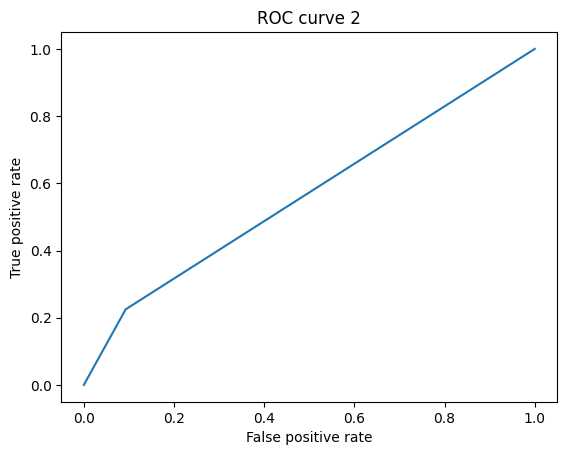

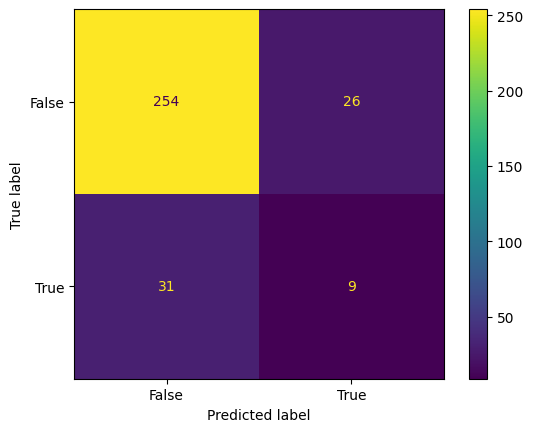

In [63]:
y_pred2 = tf.argmax(y_pred, axis=1) == 2
y_tune2 = tf.argmax(y_tune, axis=1) == 2
fpr2, tpr2, thresholds2 = metrics.roc_curve(y_tune2, y_pred2)
auc_rf2 = metrics.auc(fpr2, tpr2)
plt.plot(fpr2, tpr2, label='Keras (area = {:.3f})'.format(auc_rf1))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve 2')

print("class 2 f1 score")
print(metrics.f1_score(y_tune2, y_pred2, average="macro"))
print("class 2 precision score")
print(metrics.precision_score(y_tune2, y_pred2, average="macro"))
print("class 2 recall score")
print(metrics.recall_score(y_tune2, y_pred2, average="macro"))

confusion_matrix = metrics.confusion_matrix(y_tune2, y_pred2)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()

class 3 f1 score
0.7157288256047107
class 3 precision score
0.7535845479322194
class 3 recall score
0.6910714285714286


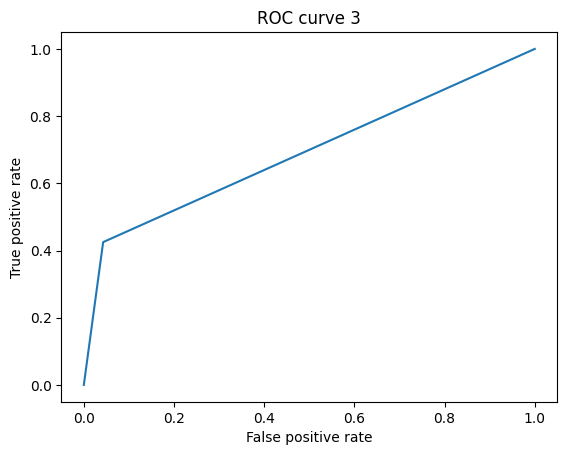

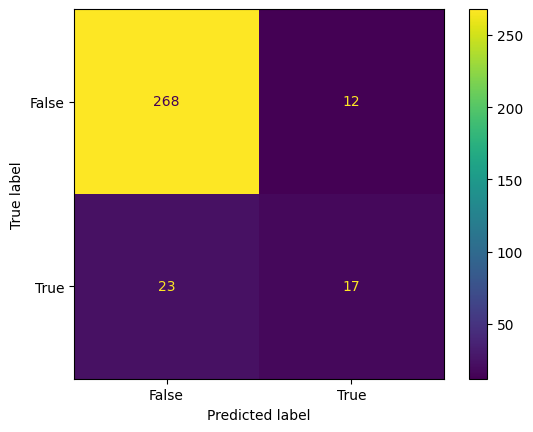

In [64]:
y_pred3 = tf.argmax(y_pred, axis=1) == 3
y_tune3 = tf.argmax(y_tune, axis=1) == 3
fpr3, tpr3, thresholds3 = metrics.roc_curve(y_tune3, y_pred3)
auc_rf3 = metrics.auc(fpr3, tpr3)
plt.plot(fpr3, tpr3, label='Keras (area = {:.3f})'.format(auc_rf1))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve 3')

print("class 3 f1 score")
print(metrics.f1_score(y_tune3, y_pred3, average="macro"))
print("class 3 precision score")
print(metrics.precision_score(y_tune3, y_pred3, average="macro"))
print("class 3 recall score")
print(metrics.recall_score(y_tune3, y_pred3, average="macro"))

confusion_matrix = metrics.confusion_matrix(y_tune3, y_pred3)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()

class 4 f1 score
0.8011788215143323
class 4 precision score
0.7562253896067883
class 4 recall score
0.9125


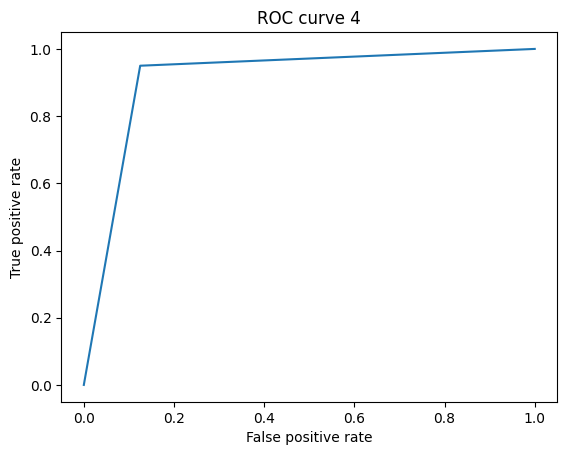

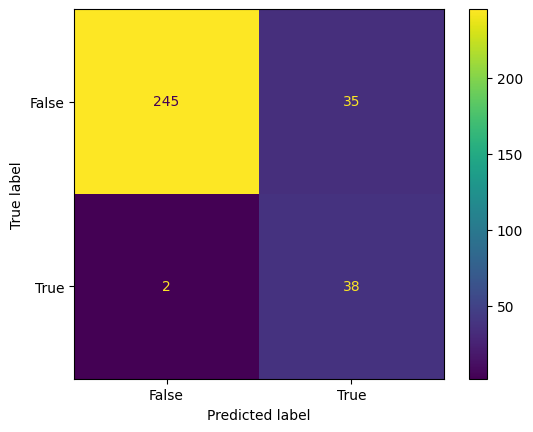

In [65]:
y_pred4 = tf.argmax(y_pred, axis=1) == 4
y_tune4 = tf.argmax(y_tune, axis=1) == 4
fpr4, tpr4, thresholds4 = metrics.roc_curve(y_tune4, y_pred4)
auc_rf4 = metrics.auc(fpr4, tpr4)
plt.plot(fpr4, tpr4, label='Keras (area = {:.3f})'.format(auc_rf1))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve 4')

print("class 4 f1 score")
print(metrics.f1_score(y_tune4, y_pred4, average="macro"))
print("class 4 precision score")
print(metrics.precision_score(y_tune4, y_pred4, average="macro"))
print("class 4 recall score")
print(metrics.recall_score(y_tune4, y_pred4, average="macro"))

confusion_matrix = metrics.confusion_matrix(y_tune4, y_pred4)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()

class 5 f1 score
0.6220901138933925
class 5 precision score
0.6122530796705299
class 5 recall score
0.6375


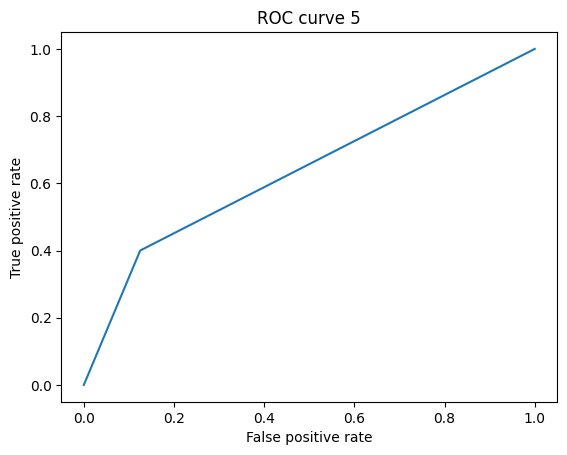

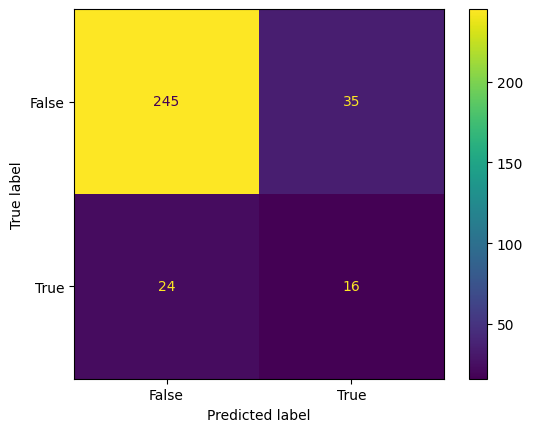

In [66]:
y_pred5 = tf.argmax(y_pred, axis=1) == 5
y_tune5 = tf.argmax(y_tune, axis=1) == 5
fpr5, tpr5, thresholds5 = metrics.roc_curve(y_tune5, y_pred5)
auc_rf5 = metrics.auc(fpr5, tpr5)
plt.plot(fpr5, tpr5, label='Keras (area = {:.3f})'.format(auc_rf1))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve 5')

print("class 5 f1 score")
print(metrics.f1_score(y_tune5, y_pred5, average="macro"))
print("class 5 precision score")
print(metrics.precision_score(y_tune5, y_pred5, average="macro"))
print("class 5 recall score")
print(metrics.recall_score(y_tune5, y_pred5, average="macro"))

confusion_matrix = metrics.confusion_matrix(y_tune5, y_pred5)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()

class 6 f1 score
0.6317606444188723
class 6 precision score
0.6332238342914499
class 6 recall score
0.6303571428571428


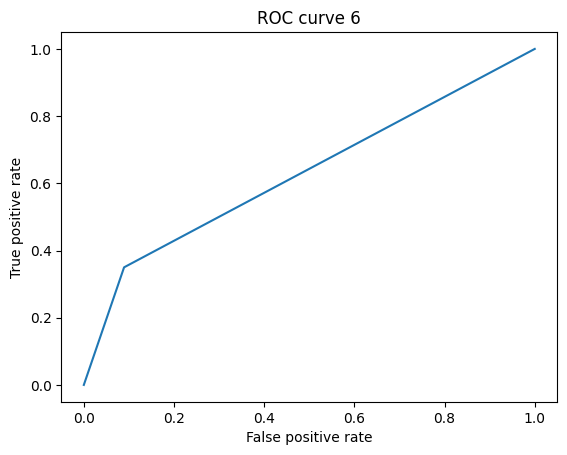

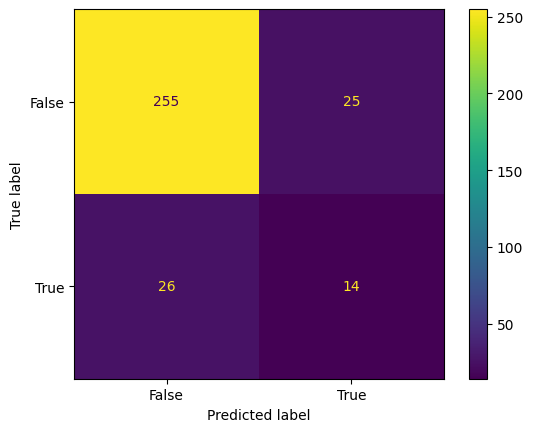

In [67]:
y_pred6 = tf.argmax(y_pred, axis=1) == 6
y_tune6 = tf.argmax(y_tune, axis=1) == 6
fpr6, tpr6, thresholds6 = metrics.roc_curve(y_tune6, y_pred6)
auc_rf6 = metrics.auc(fpr6, tpr6)
plt.plot(fpr6, tpr6, label='Keras (area = {:.3f})'.format(auc_rf1))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve 6')

print("class 6 f1 score")
print(metrics.f1_score(y_tune6, y_pred6, average="macro"))
print("class 6 precision score")
print(metrics.precision_score(y_tune6, y_pred6, average="macro"))
print("class 6 recall score")
print(metrics.recall_score(y_tune6, y_pred6, average="macro"))

confusion_matrix = metrics.confusion_matrix(y_tune6, y_pred6)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()

class 7 f1 score
0.6
class 7 precision score
0.6
class 7 recall score
0.6


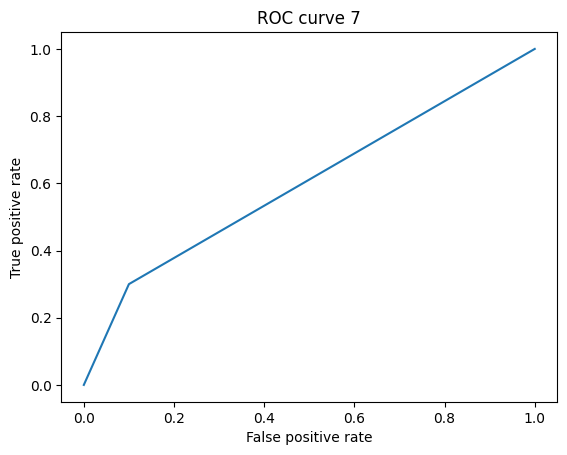

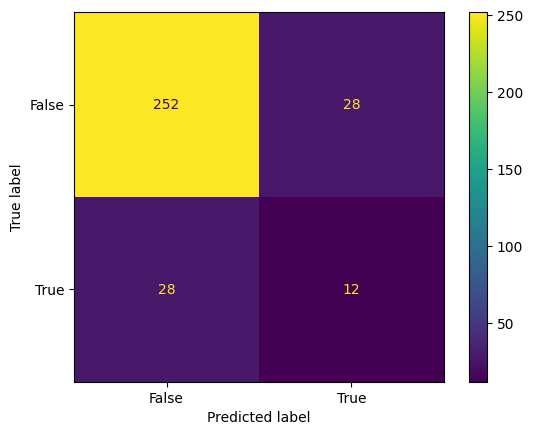

In [68]:
y_pred7 = tf.argmax(y_pred, axis=1) == 7
y_tune7 = tf.argmax(y_tune, axis=1) == 7
fpr7, tpr7, thresholds7 = metrics.roc_curve(y_tune7, y_pred7)
auc_rf7 = metrics.auc(fpr7, tpr7)
plt.plot(fpr7, tpr7, label='Keras (area = {:.3f})'.format(auc_rf1))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve 7')

print("class 7 f1 score")
print(metrics.f1_score(y_tune7, y_pred7, average="macro"))
print("class 7 precision score")
print(metrics.precision_score(y_tune7, y_pred7, average="macro"))
print("class 7 recall score")
print(metrics.recall_score(y_tune7, y_pred7, average="macro"))

confusion_matrix = metrics.confusion_matrix(y_tune7, y_pred7)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()

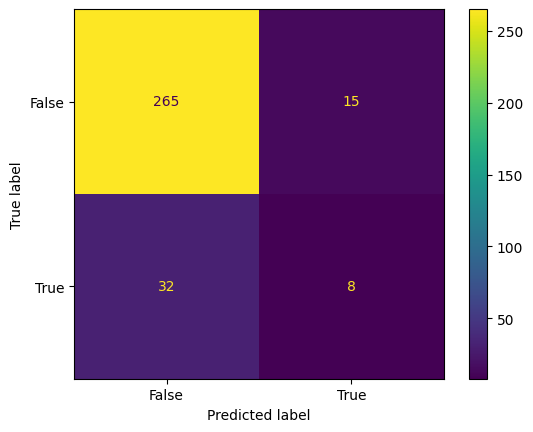

In [69]:
confusion_matrix = metrics.confusion_matrix(y_tune0, y_pred0)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()

In [70]:
n_classes = 8
fpr = [0] * 8
tpr = [0] * 8
thresholds = [0] * 8
auc_score = [0] * 8

for i in range(n_classes):
    fpr[i], tpr[i], thresholds[i] = metrics.roc_curve((y_tune_enc == i), (y_pred_enc == i))
    auc_score[i] = metrics.auc(fpr[i], tpr[i])

sum(auc_score) / n_classes

0.6589285714285715

Micro-averaged One-vs-Rest ROC AUC score:
0.66


Text(0.5, 1.0, 'ROC curve (AUC = 0.659)')

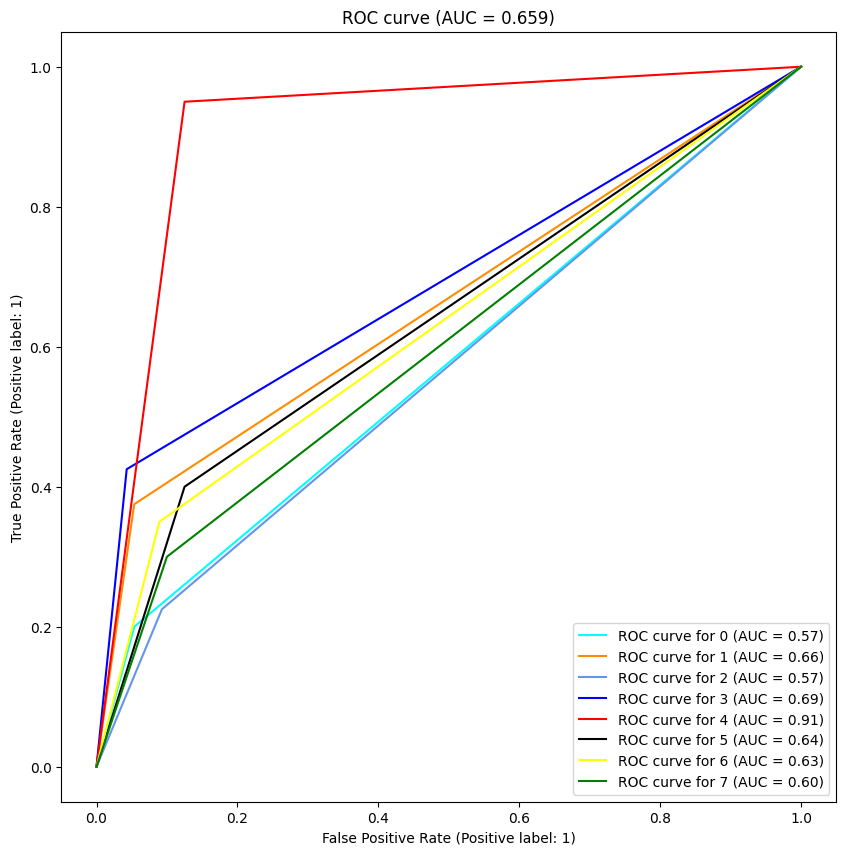

In [71]:
fig, ax = plt.subplots(figsize=(10, 10))
i = 0
colors = cycle(["aqua", "darkorange", "cornflowerblue", "blue", "red", "black", "yellow", "green"])
for class_id, color in zip(range(n_classes), colors):
    metrics.RocCurveDisplay.from_predictions(
        (y_tune_enc == i),
        (y_pred_enc == i),
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )
    i+=1


from sklearn.metrics import roc_auc_score

micro_roc_auc_ovr = roc_auc_score(
    y_tune,
    y_pred,
    multi_class="ovr",
    average="micro",
)

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr:.2f}")
plt.title('ROC curve (AUC = {:.3f})'.format(micro_roc_auc_ovr))